# Announcements
- Homework 6 posted on D2L, covers finite difference methods + probability
- Homework 7 will be posted Nov 2, covers this + next week's material. Due 11/17, final homework!
- **Term project presentations from Nov 30 to Dec 15** [Sign up](https://doodle.com/poll/ndf6a6kffx25t767) for a slot. You may discuss the projects on a conceptual level in a group, but work by yourself on the implemention, presentation and write up.
- Outlook: MCMC methods (next week), then intro to maschine learning


# Bayesian Parameter Inference on a Grid
In today's breakout room exercise we will expand on the example of measuring flux from a source, where we use the Poisson distribution to calculate the posterior $p(\mu|N)$ for the average number of photon counts from a source $\mu$ given that we observed $N$.
Here $\mu$ is the model parameter (which we vary in the computation), and $N$ is the data (which is fixed).

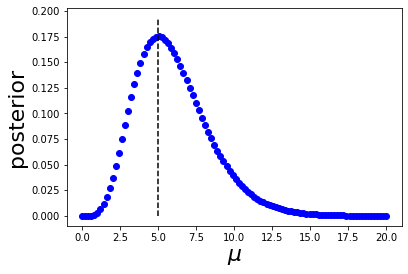

In [1]:
import numpy
import scipy.stats
import matplotlib.pyplot as plt
N = 5
mu = numpy.linspace(0.0, 20.0, 100) #grid of mu values
dmu = mu[1]-mu[0] #size of grid cell
prior = 1.0                      # uniform (proportional to a constant)
like = scipy.stats.poisson.pmf(N, mu) # evaluate P(N|mu)   
post = like * prior #Bayes theorem, with uniform prior
post /= dmu*numpy.sum(post) #normalize
plt.rcParams['figure.figsize'] = (6.0,4.0) # plt == matplotlib.pyplot
plt.plot(mu, post, 'bo');
plt.plot([N]*2, [0.0, numpy.max(post)*1.1], 'k--');
plt.xlabel(r'$\mu$', fontsize=22);
plt.ylabel('posterior', fontsize=22);

Today we will adapt this to infer parameters from an extended image, that is we will implement the PGM from Lecture 26


<img src="../Lecture26/graphics/pgms_pixelcounts.png">

Noting that $T$ and $\mu_k(F_k,T)$ are deterministic variables, we derived the following form for the PDF 

$$p(\theta,T,\{\mu_k, N_k\}) =  p(\theta)\prod_k \underbrace{P\left(N_k|\mu_k(\theta,T)\right)}_{\text{we solved this already!}}\,.$$

### Model Ingredients
The brightness profile of many galaxies is well-described by a _Sersic profile_
$$F_k(X,Y,F_0,R_0,n) = F_0\exp\left[-\frac{\sqrt{(x_k-X)^2+(y_k-Y)^2}}{R_0}^{1/n}\right]\,$$
where $x_k,y_k$ are the coordinates of pixel $k$,$X,Y$ are the (pixel) coordinates of the galaxy center in our detector, $F_0$ the bightness normalization, $R_0$ a scale related to the size of the galaxy (in pixel coordinates), and $n$ describes the slope of the profile. Since we can know the exposure time exactly, set $T=1$.

With exposure time $T$ fixed, our model parameters are $\theta =\{X,Y,F_0,R_0,n\}$.
<span style="color:blue"> __Let's write a simple class `Galaxy_Parameters` which contains the parameter values, and method to evaluate a prior for each parameter.__</span>

In [2]:
class Galaxy_Parameters():
    def __init__(self,X=50,Y=50,F0 =50,R0=5,n=2):
        #store initial values, which may be used in prior
        #these are private attributes, which can only be used within the class
        self.__X_fid = X
        self.__Y_fid = Y
        self.__F0_fid = F0
        self.__R0_fid =R0
        self.__n_fid = n
        #initialize parameter attributes, these are public and will be updated during inference
        self.X = X
        self.Y = Y
        self.F0 = F0
        self.R0 = R0
        self.n = n
    def print(self):
        print("theta.X = %.3f"%(self.X))
        print("theta.Y = %.3f"%(self.Y))
        print("theta.F0= %.3f"%(self.F0))
        print("theta.R0= %.3f"%(self.R0))
        print("theta.n =%.3f"%(self.n))
        
    #prior examples
    # you will update these later
    def F0_prior(self):
        return 1
    #for example, for the galaxy position, we can eyeball
    #let's say that's a Gaussian distribution, with width of 10 pixel
    def X_prior(self):
        sigma = 10
        return 1./(sigma*numpy.sqrt(2*numpy.pi))*numpy.exp(-0.5*(self.X-self.__X_fid)**2/sigma**2)
    def Y_prior(self):
        sigma = 10
        return 1./(sigma*numpy.sqrt(2*numpy.pi))*numpy.exp(-0.5*(self.Y-self.__Y_fid)**2/sigma**2)
    
    #we know from prior observations that 0<n<10
    #implement this!
    def n_prior(self):
        return 0

In [3]:
theta = Galaxy_Parameters(n=4)
theta.print()

In [4]:
#you can update parameter values:
theta.X = 45
theta.print()

In [5]:
#output priors
print(theta.X_prior())
print(theta.n_prior())

<span style="color:blue"> __Then implement a function `sersic_2D(x_grid,y_grid,theta)`, with `x_grid` and `y_grid` the pixel coordinates of our CCD.__ </span>

In [6]:
def sersic_2D(x_grid, y_grid,theta):
    #unpack parameter values from theta
    X = 
    Y = 
    F0 = 
    R0 = 
    n = 
    R = numpy.sqrt((x_grid-X)**2+(y_grid-Y)**2)
    return 

In [7]:
#Let's say we have a CCD with 100 x 100 pixels
#for simplicity, let's say our pixel scale is one, so x[i,j] =i
N_pix = 100
x_grid = numpy.zeros((N_pix,N_pix))
y_grid = numpy.zeros((N_pix,N_pix))
# now set x_k, y_k (use)
for i in range(N_pix):
    for j in range(N_pix):

#now evaluate the model
image = sersic_2D(x_grid,y_grid,theta)

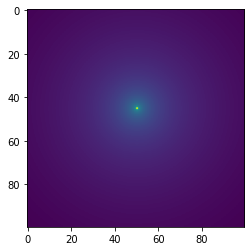

In [8]:
#let's plot a contour to show that it works
plt.imshow(image)


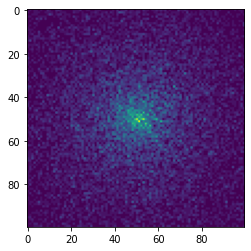

In [9]:
#to simulate data, let's create a new parameter instance (for later reference)
theta_data = Galaxy_Parameters(F0=20)
data =numpy.random.poisson(sersic_2D(x_grid,y_grid,theta_data))
plt.imshow(data)

Now we have "data", and we can apply our Bayesian skills to infer the posterior for the galaxy parameters. Compared to the flux measurement example from Lecture 27, we now have multiple pixels, and multiple model parameters.

_In order to speed up the debugging, let's start in one dimension, and assume that we are given all model parameters except $F_0$. (You will vary multiple parameters in Homework 7.)

<span style="color:blue"> __Using the noisy `data` image from above as fixed input, generalize the flux measurement example to infer $F_0$ from all pixels.__ </span>

- First, rewrite the flux measurement code snippet for as function `P_N_given_mu_pixel(model_k,data_k)` that takes as input the model value `model_k` for pixel $k$ and data value for pixel $k$.
- **Discuss: what happens to the $\mu$ prior from the above example when we calculate the posterior?**
- Then calculate $\prod_k P\left(N_k|\mu_k(\theta)\right)$ for one model $\theta$. _Note that adding $\log(P\left(N_k|\mu_k(\theta)\right))$ may be more stable numerically._
- Finally, evaluate $p(\theta|\{N_k\})$ on a grid in $F_0$, holding all other parameters fixed at their fiducial values.

In [10]:
def P_N_given_mu_pixel(model_k,data_k):

def P_N_given_mu(model, data):
    N_pix =model.shape[0]
    log_like = 0. 
    for i in range(N_pix):
        for j in range(N_pix):
    return log_like

N_grid = 10
F = numpy.linspace(1,100,N_grid)
dF = F[1]-F[0] #grid size
log_post = numpy.zeros(N_grid)
for i in range(N_grid):
    #update model parameters
    #evaluate model
    #evaluate likelihood
    #include the prior!


In [11]:
#let's look at the values of log_p before plotting it
log_post

array([ -36217.1575985 ,  -17852.78451524,  -29176.8658008 ,
        -44704.53563826,  -62021.68937579,  -80336.04570173,
        -99287.253815  , -118680.71254342, -138399.30630284,
       -158367.04753029])

That's a large range, and visulizing it straight up may be problematic.
So we'll substract the maximum value before exponentiating. **Why can we do that?**


In [12]:
post = numpy.exp(log_post-numpy.max(log_post))
#finally, normalize
post/=numpy.sum(post)*dF

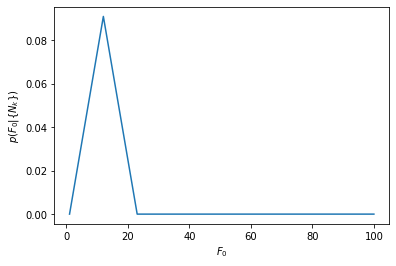

In [13]:
plt.xlabel('$F_0$');
plt.ylabel('$p(F_0|\{N_k\})$');
plt.plot(F,post);
plt.show()

If this plot looks approximately as you expected, you can rerun it with a larger number for `N_grid` for better resolution. (That may take some time, hence we used a smaller value for debuggin.)